Summary
-------

On April 15, 1912 the RMS Titanic carrying 2,224 passengers (including crew) struck an iceberg and over the next two hours slid below the icy waves along with over 1,500 dead by the time the RMS Carpathia over 6 hours later.  Oddly enough, the RMS Titanic was actually carrying more lifeboats than required by law which was based on gross tonnage, not number of passengers.  If every life boat has been successfully launched at full capacity (most were not fully loaded and two drifted away as she sunk) there would have only been room for 1,178 in total, still well shy the number of people aboard.

This is an exploration of using machine learning to determine factors in survival.  The dataset is of passengers only (crew numbered about 885 people and a survival rate of around 24%).  Titanic's passengers numbered approximately 1,317 people: 324 in First Class, 284 in Second Class, and 709 in Third Class but this data set has a total pf 1,309 passenger records.  If the RMS Titanic had a full ship of 3,339 passengers and crew the accident would have been much deadlier

The Data
--------

* PassengerId 	Unique Identifier
* Survival        Survival (0 = No; 1 = Yes)
* Pclass 1 = First Class, 2 = Second Class, 3 = Third Class
* Name Last Name, Surname First Name and additional qualifier if needed
* Sex  Male or Female
* Age	Age, Fractional if Age less than One (1) If the Age is Estimated, it is in the form xx.5
* SibSp	Number of Siblings/Spouses Aboard
* Parch	Number of Parents/Children Aboard
* Ticket	Ticket Number
* Fare	Passenger Fare
* Cabin	Cabin with the letter being deck and number is cabin, decks should be A-G
* Embarked Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

**PLEASE NOTE THIS IS IN PROGRESS AND HAS NOT BEEN COMPLETED**

As this is my first foray into machine learning, please comment below with any suggestions or notes!  

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# sns.set_style('whitegrid',{'axes.grid' : False})
# sns.set_context(rc = {'patch.linewidth': 0.0})
# bar_settings = {'color': sns.xkcd_rgb['grey'], 'ci': None}
# color_settings = {'color': sns.xkcd_rgb['grey']}
from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

Data Selection and Cleaning
---------------------------

First I wanted to get an understanding of the data and see how many are missing values.  At first I need to import from csv's both the training and the test data sets.

In [51]:
# get titanic & test csv files as a DataFrame
train_df = pd.read_csv("~/Desktop/pythonexplore/train.csv")
test_df = pd.read_csv("~/Desktop/pythonexplore/test.csv")

# if you want to see where values are missing
print("THIS IS THE TRAIN_DF INFO")
train_df.info()
print("-------------------------")
print("THIS IS THE TEST_DF INFO")
test_df.info()

THIS IS THE TRAIN_DF INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
-------------------------
THIS IS THE TEST_DF INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-nu

Cleaning Data
-------------

There are some missing values, some are simpler than others. The first one is a quick fill for the missing single fare with the median value.  A quick check shows that most of the nulls are under Age and Cabin and we will deal with them next.

In [52]:
# Embarked only in train_df, fill the two missing values with the most occurred value, which is "S".
train_df["Embarked"] = train_df["Embarked"].fillna("S")

# Fill in the single missing fare with median value
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# Convert fare from float to int
train_df['Fare'] = train_df['Fare'].astype(int)
test_df['Fare'] = test_df['Fare'].astype(int)

# Count all the null values
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Filling Missing Ages
--------------------

There is a fair number of missing age.  First I need to understand what the distribution looks like currently so I can check after I run RandomForestRegressor to make sure that it doesn't look off.  [Poonam's work][1] was an amazing asset as this is all new to me. 

  [1]: https://www.kaggle.com/poonaml/titanic/titanic-survival-prediction-end-to-end-ml-pipeline

(array([ 40.,  14.,  15.,  31.,  79.,  98.,  85.,  84.,  73.,  45.,  35.,
         35.,  29.,  16.,  13.,  11.,   4.,   5.,   1.,   1.]),
 array([  0.42 ,   4.399,   8.378,  12.357,  16.336,  20.315,  24.294,
         28.273,  32.252,  36.231,  40.21 ,  44.189,  48.168,  52.147,
         56.126,  60.105,  64.084,  68.063,  72.042,  76.021,  80.   ]),
 <a list of 20 Patch objects>)

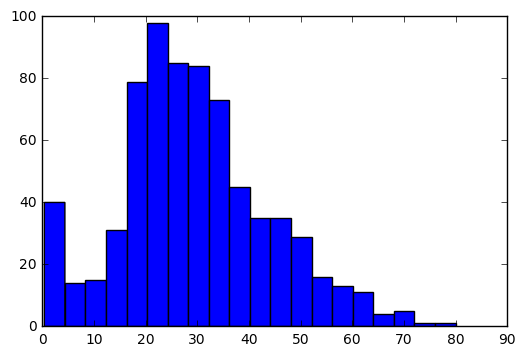

In [53]:
# Quick histogram of age with NaN's ignored so it will plot
plt.hist(train_df['Age'].dropna(),bins=20)


In [54]:
from sklearn.ensemble import RandomForestRegressor
#predicting missing values in age using Random Forest
def fill_missing_age(df):
    
    #Feature set
    age_df = df[['Age','Pclass','SibSp','Parch','Fare']]
    # Split sets into train and test
    train  = age_df.loc[ (df.Age.notnull()) ]# known Age values
    test = age_df.loc[ (df.Age.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df

In [55]:
# Now apply the function to the data for both training and test data
train_df=fill_missing_age(train_df)
test_df=fill_missing_age(test_df) 

# Verify that the NaNs are no longer there for age
train_df.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Plot the final result after changing the Ages to make sure it looks similiar in distribution and then do a quick sanity check with describe to make sure nothing went negative.

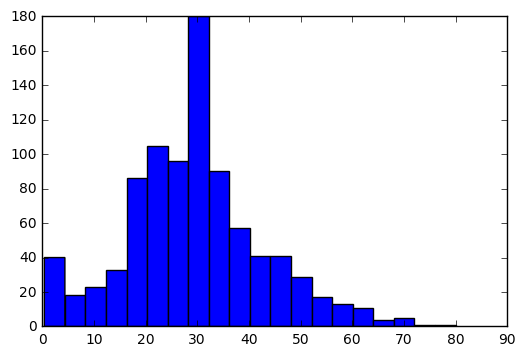

count    891.000000
mean      29.520323
std       13.502413
min        0.420000
25%       21.000000
50%       28.348430
75%       36.000000
max       80.000000
Name: Age, dtype: float64

In [56]:
plt.hist(train_df['Age'],bins=20)
plt.show()
train_df['Age'].describe()

Feature Engineering
-------------------

In order to make the machine learning be more accurate some feature engineering is needed.  Cabin is only moderately useful, I cannot really create the correct cabin placements without going somewhere else to get that information.  The Third Class passenger cabins in the bow was under water in less than 20 minutes after the strike, but there were also cabins in the stern as well.  

First I am going to focus on Names and pulling some more information out of those.  Poonam's work again was vital.

In [57]:
import re

# function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    #If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles
titles = train_df["Name"].apply(get_title)

#Add in the title column with all the current values so we can then manually change them
train_df["Title"] = titles
# Check count of title values to give the list of titles that need to be changed
# print(pd.value_counts(titles))

# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Also reassign mlle, ms, and mme accordingly
train_df.loc[train_df["Title"] == "Mlle", "Title"] = 'Miss'
train_df.loc[train_df["Title"] == "Ms", "Title"] = 'Miss'
train_df.loc[train_df["Title"] == "Mme", "Title"] = 'Mrs'
train_df.loc[train_df["Title"] == "Dona", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Lady", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Countess", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Capt", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Col", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Don", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Major", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Rev", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Sir", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Jonkheer", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Dr", "Title"] = 'Rare Title'

titles = train_df["Name"].apply(get_title)
print(pd.value_counts(titles))

#Add in the title column.
test_df["Title"] = titles

# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Also reassign mlle, ms, and mme accordingly
test_df.loc[test_df["Title"] == "Mlle", "Title"] = 'Miss'
test_df.loc[test_df["Title"] == "Ms", "Title"] = 'Miss'
test_df.loc[test_df["Title"] == "Mme", "Title"] = 'Mrs'
test_df.loc[test_df["Title"] == "Dona", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Lady", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Countess", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Capt", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Col", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Don", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Major", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Rev", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Sir", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Jonkheer", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Dr", "Title"] = 'Rare Title'




Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Jonkheer      1
Sir           1
Mme           1
Don           1
Capt          1
Ms            1
Lady          1
Name: Name, dtype: int64
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Jonkheer      1
Sir           1
Mme           1
Don           1
Capt          1
Ms            1
Lady          1
Name: Name, dtype: int64


In [58]:
test_df['Title'].value_counts()

Mr            228
Miss          101
Mrs            59
Master         23
Rare Title      7
Name: Title, dtype: int64

In [64]:
train_df['Agebin'] = pd.cut(train_df['Age'],[0,10,20,30,40,50,60,70,80])
test_df['Agebin'] = pd.cut(test_df['Age'],[0,10,20,30,40,50,60,70,80])

In [62]:
train_df['Agebin']

0      (20, 30]
1      (30, 40]
2      (20, 30]
3      (30, 40]
4      (30, 40]
5      (20, 30]
6      (50, 60]
7       (0, 10]
8      (20, 30]
9      (10, 20]
10      (0, 10]
11     (50, 60]
12     (10, 20]
13     (30, 40]
14     (10, 20]
15     (50, 60]
16      (0, 10]
17     (30, 40]
18     (30, 40]
19     (20, 30]
20     (30, 40]
21     (30, 40]
22     (10, 20]
23     (20, 30]
24      (0, 10]
25     (30, 40]
26     (20, 30]
27     (10, 20]
28     (20, 30]
29     (20, 30]
         ...   
861    (20, 30]
862    (40, 50]
863    (10, 20]
864    (20, 30]
865    (40, 50]
866    (20, 30]
867    (30, 40]
868    (20, 30]
869     (0, 10]
870    (20, 30]
871    (40, 50]
872    (30, 40]
873    (40, 50]
874    (20, 30]
875    (10, 20]
876    (10, 20]
877    (10, 20]
878    (20, 30]
879    (50, 60]
880    (20, 30]
881    (30, 40]
882    (20, 30]
883    (20, 30]
884    (20, 30]
885    (30, 40]
886    (20, 30]
887    (10, 20]
888    (10, 20]
889    (20, 30]
890    (30, 40]
Name: Agebin, dtype: cat

In [63]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

labelEnc=LabelEncoder()

cat_vars=['Embarked','Sex','Title','Agebin']
for col in cat_vars:
    train_df[col]=labelEnc.fit_transform(train_df[col])
    test_df[col]=labelEnc.fit_transform(test_df[col])

train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Agebin
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7,NaN,2,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71,C85,0,3,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7,NaN,2,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53,C123,2,3,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8,NaN,2,2,3
